In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_FilmTrust'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/filmtrust'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load(open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','rb'))

In [4]:
dftrain.columns

Index(['index', 'userId', 'itemId', 'rating', 'f_mean_on_self',
       'f_min_on_self', 'f_max_on_self', 'f_sum_on_self', 'f_mean_on_other',
       'f_min_on_other', 'f_max_on_other', 'f_sum_on_other', 'random_dstype',
       'flag_train', 'f_na_mean_on_self', 'f_na_min_on_self',
       'f_na_max_on_self', 'f_na_sum_on_self', 'f_na_mean_on_other',
       'f_na_min_on_other', 'f_na_max_on_other', 'f_na_sum_on_other',
       'user_idx', 'item_idx'],
      dtype='object')

In [5]:
denseCols=dftrain.columns[dftrain.columns.str.startswith('f_')].tolist()

In [6]:
naCols=dftrain.columns[dftrain.columns.str.startswith('f_na')].tolist()

In [7]:
denseCols

['f_mean_on_self',
 'f_min_on_self',
 'f_max_on_self',
 'f_sum_on_self',
 'f_mean_on_other',
 'f_min_on_other',
 'f_max_on_other',
 'f_sum_on_other',
 'f_na_mean_on_self',
 'f_na_min_on_self',
 'f_na_max_on_self',
 'f_na_sum_on_self',
 'f_na_mean_on_other',
 'f_na_min_on_other',
 'f_na_max_on_other',
 'f_na_sum_on_other']

In [8]:
naCols

['f_na_mean_on_self',
 'f_na_min_on_self',
 'f_na_max_on_self',
 'f_na_sum_on_self',
 'f_na_mean_on_other',
 'f_na_min_on_other',
 'f_na_max_on_other',
 'f_na_sum_on_other']

In [9]:
for myNm in naCols:
    dftrain[myNm]=dftrain[myNm].astype(int)
    dfvalid[myNm]=dfvalid[myNm].astype(int)

### Dataset and DataLoader

In [10]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [11]:
dstrain=cfdata(dftrain[['user_idx','item_idx']+denseCols],dftrain['rating'],denseCols)
dsvalid=cfdata(dfvalid[['user_idx','item_idx']+denseCols],dfvalid['rating'],denseCols)

In [12]:
dftrain.shape

(32036, 24)

In [13]:
bs=32

In [14]:
dltrain=DataLoader(dstrain,bs,True)

In [15]:
dlvalid=DataLoader(dsvalid,bs,False)

## Model Architecture

In [59]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=50
n_emb_item=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.2
hidden=[25,25,10]
dropouts=[0.3,0.4,0.2]

In [60]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [61]:
#[mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb]=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
#pretrain_wts=None

In [62]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,autoenc_cols,pretrain_wts,\
                 dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse"):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.create_architecture()
        self.init_parameters()
        
        if pretrain_wts is not None:
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        
        
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin_bias=nn.Linear(3,1)
        self.lin2= nn.Sequential (nn.Linear(self.len_dense_cols,self.hidden[1]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[1]) )
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1]+1,self.hidden[2]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[2]))
        self.lin4=nn.Linear(self.hidden[2],1)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.zeros_(self.ub.weight.data)
        nn.init.zeros_(self.ib.weight.data)
        nn.init.kaiming_normal_(self.lin1[0].weight.data)
        nn.init.kaiming_normal_(self.lin2[0].weight.data)
        nn.init.kaiming_normal_(self.lin3[0].weight.data)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_item(items))
        users_bias=self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias=self.emb_dropout(self.ib(Xb[:,1].long()))
        embed=torch.cat([users,items],1)
        out1=self.lin1(embed)
        bias=torch.cat([users_bias,items_bias,users_bias+items_bias],1)
        biased=self.lin_bias(bias)
           
        
        denses=Xb[:,2:]
        out2=self.lin2(denses)
        
        out3=torch.cat([out1,out2,biased],1)
        
        out4=self.lin3(out3)
        
        out5=self.lin4(out4)
        
        out=self.sigmoid(out5)
        
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [20]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")

In [21]:
cfobj

cf(
  (emb_user): Embedding(1509, 50)
  (emb_item): Embedding(2072, 50)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=16, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (lin3): Sequential(
    (0): Linear(in_features=51, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [22]:
for Xb, Yb in dltrain:
    break

In [23]:
Xb.shape, Yb.shape

(torch.Size([32, 18]), torch.Size([32, 1]))

In [24]:
Xb.dtype

torch.float32

In [25]:
cfobj.forward(Xb,Yb)

(tensor([[2.2710],
         [2.3628],
         [2.6586],
         [2.7760],
         [3.6711],
         [2.7139],
         [2.5860],
         [2.5886],
         [2.6185],
         [2.4960],
         [2.5056],
         [2.7446],
         [2.0464],
         [2.7373],
         [2.4744],
         [2.1429],
         [1.9415],
         [2.3495],
         [2.7232],
         [2.3320],
         [2.6021],
         [2.1038],
         [3.0573],
         [2.0092],
         [2.4660],
         [2.3971],
         [2.3977],
         [2.2761],
         [2.2182],
         [2.7414],
         [2.3531],
         [2.5614]], grad_fn=<AddBackward0>),
 tensor(1.1073, grad_fn=<MseLossBackward>))

## Learner

In [26]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [28]:
device='cuda:0'

In [29]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")

In [30]:
cfobj=cfobj.to(device)

In [31]:
cfobj

cf(
  (emb_user): Embedding(1509, 50)
  (emb_item): Embedding(2072, 50)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=16, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (lin3): Sequential(
    (0): Linear(in_features=51, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [32]:
wd=1e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [33]:
len(dltrain)

1002

In [34]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

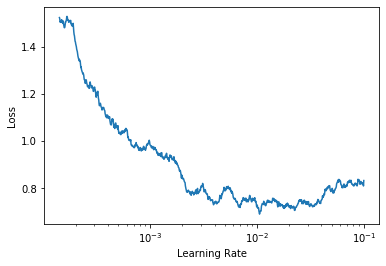

In [35]:
learner.plot_lrs(50)

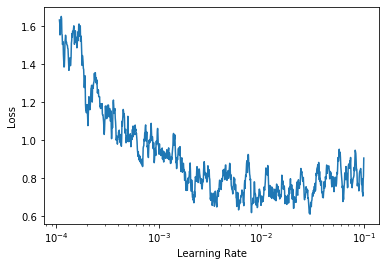

In [36]:
learner.plot_lrs(10)

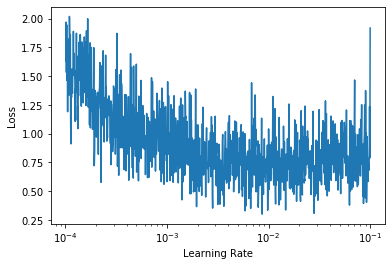

In [37]:
learner.plot_lrs(1)

In [63]:
del cfobj
torch.cuda.empty_cache()

In [64]:
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))

In [65]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")
cfobj=cfobj.to(device)

In [66]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=False
    cfobj.emb_item.weight.requires_grad=False
    cfobj.ib.weight.requires_grad=False
    cfobj.ub.weight.requires_grad=False

In [67]:
wd=5e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=1e-2,end_lr=5e-4,wd_mult=1.15)

In [68]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.005 Weight Decay 0.0005 Train Loss:0.7226042104457429                 Valid Loss:0.6867834373351631 Train RMSE:0.8393457005647593 Valid RMSE:0.8173889224817326 Train MSE:0.7226042104457429 Valid MSE:0.6867834373351631                 Train MAE:0.6673742594595203 Valid MAE:0.6436205744196516
Epoch:1 Learning rate 0.0015811388300841897 Weight Decay 0.000575 Train Loss:0.6373552435380732                 Valid Loss:0.662724657616484 Train RMSE:0.7902339487152374 Valid RMSE:0.8034917174843634 Train MSE:0.6373552435380732 Valid MSE:0.662724657616484                 Train MAE:0.6230411595272685 Valid MAE:0.6471764765201359
Epoch:2 Learning rate 0.0005 Weight Decay 0.0006612499999999999 Train Loss:0.6156483637745271                 Valid Loss:0.6592592856752764 Train RMSE:0.7767934127830565 Valid RMSE:0.8010273517057546 Train MSE:0.6156483637745271 Valid MSE:0.6592592856752764                 Train MAE:0.6122599492470423 Valid MAE:0.6433817801672385
Epoch:3 Learning rat

In [69]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=True
    cfobj.emb_item.weight.requires_grad=True
    cfobj.ib.weight.requires_grad=True
    cfobj.ub.weight.requires_grad=True

In [71]:
if 1==1:
    # optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
    for param_group in optimizer.param_groups:
        param_group['lr']=5e-3
    learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=5e-3,end_lr=1e-4,wd_mult=1.15)
    learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.005 Weight Decay 0.0008745031249999997 Train Loss:0.679971852702295                 Valid Loss:0.675612369808582 Train RMSE:0.81605648560466 Valid RMSE:0.8100385299051287 Train MSE:0.679971852702295 Valid MSE:0.675612369808582                 Train MAE:0.6469861099463023 Valid MAE:0.6525303491758644
Epoch:1 Learning rate 0.0007071067811865475 Weight Decay 0.0010056785937499996 Train Loss:0.6441470517102116                 Valid Loss:0.6572158705750737 Train RMSE:0.794687771841706 Valid RMSE:0.7985990577479518 Train MSE:0.6441470517102116 Valid MSE:0.6572158705750737                 Train MAE:0.62579990884739 Valid MAE:0.6361502042604149
Epoch:2 Learning rate 9.999999999999999e-05 Weight Decay 0.0011565303828124994 Train Loss:0.6119483834701384                 Valid Loss:0.6539404176243948 Train RMSE:0.7732198460564121 Valid RMSE:0.7969308161251153 Train MSE:0.6119483834701384 Valid MSE:0.6539404176243948                 Train MAE:0.6071900350604943 Valid MAE:0.6

In [72]:
learner.run_epochs(dltrain,dlvalid,4)

Epoch:0 Learning rate 0.005 Weight Decay 0.0008745031249999997 Train Loss:0.6788673208442753                 Valid Loss:0.6704659273318194 Train RMSE:0.8158610909955287 Valid RMSE:0.8080517420586861 Train MSE:0.6788673208442753 Valid MSE:0.6704659273318194                 Train MAE:0.6452167866353741 Valid MAE:0.651725837670335
Epoch:1 Learning rate 0.001880301546543197 Weight Decay 0.0010056785937499996 Train Loss:0.6488246448828788                 Valid Loss:0.6574351459468176 Train RMSE:0.7978139028998131 Valid RMSE:0.800046721666184 Train MSE:0.6488246448828788 Valid MSE:0.6574351459468176                 Train MAE:0.6267540716601465 Valid MAE:0.6455964593712343
Epoch:2 Learning rate 0.0007071067811865476 Weight Decay 0.0011565303828124994 Train Loss:0.6226194472370034                 Valid Loss:0.6458521772415267 Train RMSE:0.78080140468581 Valid RMSE:0.792000568901357 Train MSE:0.6226194472370034 Valid MSE:0.6458521772415267                 Train MAE:0.612744100436479 Valid MAE:0

In [73]:
learner.generate_scores=True

In [74]:
learner.run_epoch(dlvalid,False)

(0.6439463999293266, 0.6285758013025337, 0.7909755759821505)

In [75]:
dfvalid['pred_dnnrec']=np.concatenate(learner.scores)

In [76]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_dnnrec']))

0.8046374576389562

In [77]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [78]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.612383,0.782549,0.611985,0.248881,No-cold-start
1,dnnrec,0.918829,0.958555,0.777119,0.088405,User-Cold-Start
2,dnnrec,0.991179,0.995580,0.763436,-0.062407,Item-Cold_start
3,dnnrec,1.600917,1.265274,1.088005,-0.380101,User-Item-cold-start
0,dnnrec,0.612383,0.782549,0.611985,0.248881,0
1,dnnrec,0.959754,0.979670,0.788285,0.062092,1
0,dnnrec,0.647441,0.804637,0.629778,0.226053,0


In [79]:
results_concat.shape

(77, 6)

In [80]:
results_concat=pd.concat([results_concat,result_dnnrec],axis=0)

In [81]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','wb'))

In [82]:
results_concat

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,0.638513,0.799070,0.622871,0.216831,No-cold-start
1,biasedmatrixfactorization,0.925556,0.962058,0.771413,0.081731,User-Cold-Start
2,biasedmatrixfactorization,1.016274,1.008104,0.775404,-0.089305,Item-Cold_start
3,biasedmatrixfactorization,1.649868,1.284472,1.099969,-0.422300,User-Item-cold-start
0,biasedmatrixfactorization,0.638513,0.799070,0.622871,0.216831,0
1,biasedmatrixfactorization,0.971243,0.985517,0.786175,0.050864,1
0,biasedmatrixfactorization,0.672094,0.819813,0.639352,0.196583,0
0,svdplusplus,0.648519,0.805307,0.643882,0.204558,No-cold-start
1,svdplusplus,0.939454,0.969254,0.780966,0.067942,User-Cold-Start
2,svdplusplus,0.964594,0.982138,0.773659,-0.033912,Item-Cold_start


In [83]:
import pickle
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load (open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','rb'))
results_concat.to_csv(f'{PATH}/filmtrust_results.csv',index=False)

In [84]:
PATH

'/home/kirana/Documents/phd/experiment1_new/DNNREC_FilmTrust'